<a href="https://colab.research.google.com/github/kuzminRM/-MailRuInternSpring2022/blob/main/Mail_Intern_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import fbeta_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import xgboost as xgb

# у colab стоит старый xgboost
!pip install xgboost -U

In [ ]:
data = load_breast_cancer()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['target'] = data['target']

# в DESCR написано достаточно информации чтобы понять с чем имеем дело
print(data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Разделяем на обучающуб и тестовыю выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df['target'], test_size=0.15, random_state=0)

# Baseline model (0.98)

Строим модель, обученную на данных без каких-либо преобразований

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:08:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


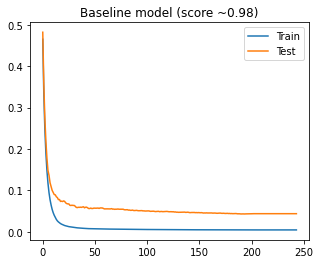

In [ ]:
# обучаем модель
baseline_model = xgb.XGBClassifier(n_estimators=500, random_state=0)
eval_set = [(X_train, y_train), (X_test, y_test)]
baseline_model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=eval_set, verbose=False)

# получаем значения метрики
results = baseline_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(epochs)

# рисуем
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax1.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax1.legend()
ax1.set_title(f'Baseline model (score ~{fbeta_score(y_test, baseline_model.predict(X_test), beta=1)})');

В качестве примера предварительной обработки данных посмотрим на межфакторную корреляцию признаков.

На приведенном ниже графике видно мы имеем дело с сильной межфакторной корреляцией различных переменных, что в свою очередь ведет к ухудшению модели.

Взглянув на карту можно заметить, что в датасете, например, представлена таккая группа признаков как периметр, радиус и площадь. Межфакторная корреляция внутри этой группы очень сильная (что имеет вполне понятную природу). Попробуем оставить только площадь из этих трех признкаов.

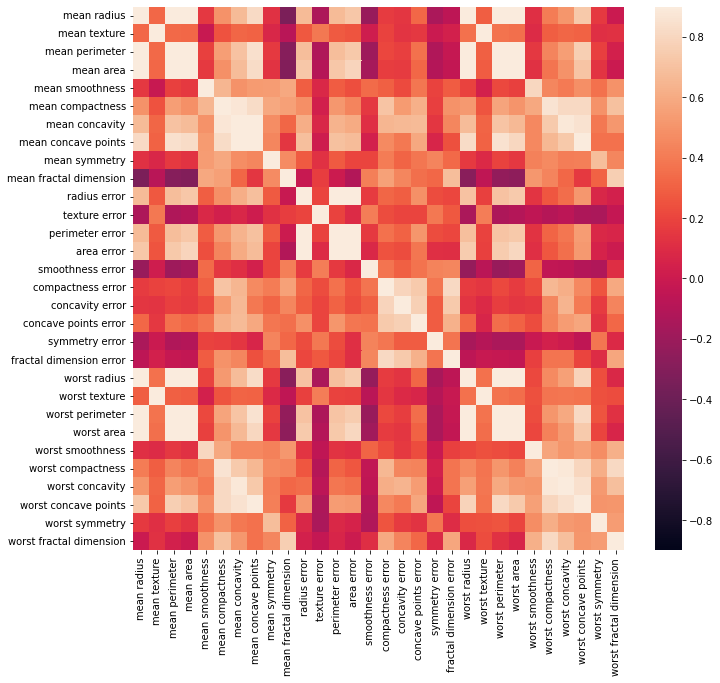

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(11, 10))
sns.heatmap(X_train.corr(), annot = False, vmin=-0.9, vmax=0.9, ax=ax1)

In [ ]:
new_cols = list(X_train.columns)

new_cols.remove('mean radius')
new_cols.remove('mean perimeter')
new_cols.remove('radius error')
new_cols.remove('perimeter error')
new_cols.remove('worst perimeter')
new_cols.remove('worst radius')

# New model (0.99)

Обучаем новую модель на измененных данных, получаем улучшение f1-метрики на 0.1 и это при том, что алгоритм и так приктичсеки идеально делал предсказывания

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:08:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


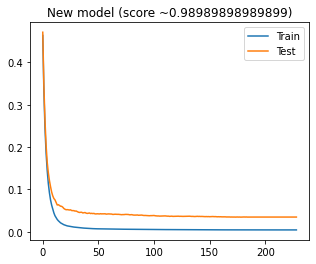

In [ ]:
# обучаем модель
new_model = xgb.XGBClassifier(n_estimators=500, random_state=0)
eval_set = [(X_train[new_cols], y_train), (X_test[new_cols], y_test)]
new_model.fit(X_train[new_cols], y_train, early_stopping_rounds=50, eval_set=eval_set, verbose=False)

# получаем значения метрики
results = new_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(epochs)

# рисуем
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax1.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax1.legend()
ax1.set_title(f'New model (score ~{fbeta_score(y_test, new_model.predict(X_test[new_cols]), beta=1)})');